In [1]:
import time
import json
import datetime
import pandas as pd
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [3]:
def retrieve_data(data_path = "../data/", start_idx=0, stop_idx=60):
    # list to store files
    f_store = []
    results = {}
    
    # Iterate directory
    for file_name in os.listdir(data_path):
        # check if current file_path is a file
        if os.path.isfile(os.path.join(data_path, file_name)):
            # add filename to list
            f_store.append(file_name)

    flag = True
    for file_name in f_store:
        data = {}
        tmp_dt = ''
        # Open the JSON file
        with open(data_path + file_name) as file:
            data = json.load(file)
        for i in range(start_idx, stop_idx+1):
            if data:
                if i == start_idx:
                    tmp_dt = data[str(i)]['timestamp']
                if flag:
                    if i == start_idx:
                        results['timestamp'] = [tmp_dt]
                    results[data[str(i)]['name']] = [data[str(i)]['value']]
                else:
                    if i == start_idx:
                        results['timestamp'].append(tmp_dt)
                    results[data[str(i)]['name']].append(data[str(i)]['value'])
        flag = False
    #print(results)
    return results

In [4]:
res = retrieve_data()

In [5]:
df = pd.DataFrame.from_dict(res)
df.head()

,timestamp,GECO/MPRX_DI_DOS1_Flowrate_50Hz_mlmin_I,GECO/MPRX_DI_DOS2_Flowrate_50Hz_mlmin_I,GECO/MPRX_DI_DOS3_Flowrate_50Hz_mlmin_I,GECO/MPRX_DI_FOG_Flowrate_50Hz_lmin_I,GECO/MPRX_DI_FOG_Foam_Air_Factor_I,GECO/MPRX_DI_FOG_Foam_Density_gl_I,GECO/MPRX_DI_FOG_Foam_Loss_Factor_pct_I,GECO/MPRX_DI_FOG_Foamingagent_pct_R,GECO/MPRX_DI_FOG_RESERVED_Foamingagent_cpct_I,...,GECO/MP_DOS3_Flowrate_current_mlmin_I,GECO/MP_Error_Any_Active,GECO/MP_Master_On,GECO/MP_Mixer_Run,GECO/MP_Pressure_reached,GECO/MP_Pump_Pressure_Current_bar_R,GECO/MP_Pump_Run,GECO/MP_Water_Run,GECO/MP_Waterflowrate_current_Lh_R,GECO/MP_Waterprobe_Upper_Cov
0,"04.08.2024 17:15:38,264167",0,0,0,0,100,0,0,0.0,0,...,0,True,True,False,False,0.065080,False,False,0.0,True
1,"04.08.2024 17:15:43,914538",0,0,0,0,100,0,0,0.0,0,...,0,True,True,False,False,0.064537,False,False,0.0,True
2,"04.08.2024 17:15:46,755341",0,0,0,0,100,0,0,0.0,0,...,0,True,True,False,False,0.062417,False,False,0.0,True
3,"04.08.2024 17:15:49,477751",0,0,0,0,100,0,0,0.0,0,...,0,True,True,False,False,0.062002,False,False,0.0,True
4,"04.08.2024 17:15:52,236622",0,0,0,0,100,0,0,0.0,0,...,0,True,True,False,False,0.063407,False,False,0.0,True


In [35]:
len(df)

5961

In [ ]:
df['timestamp']= pd.to_datetime(df['timestamp'],  format='%d.%m.%Y %H:%M:%S,%f')
df.head()

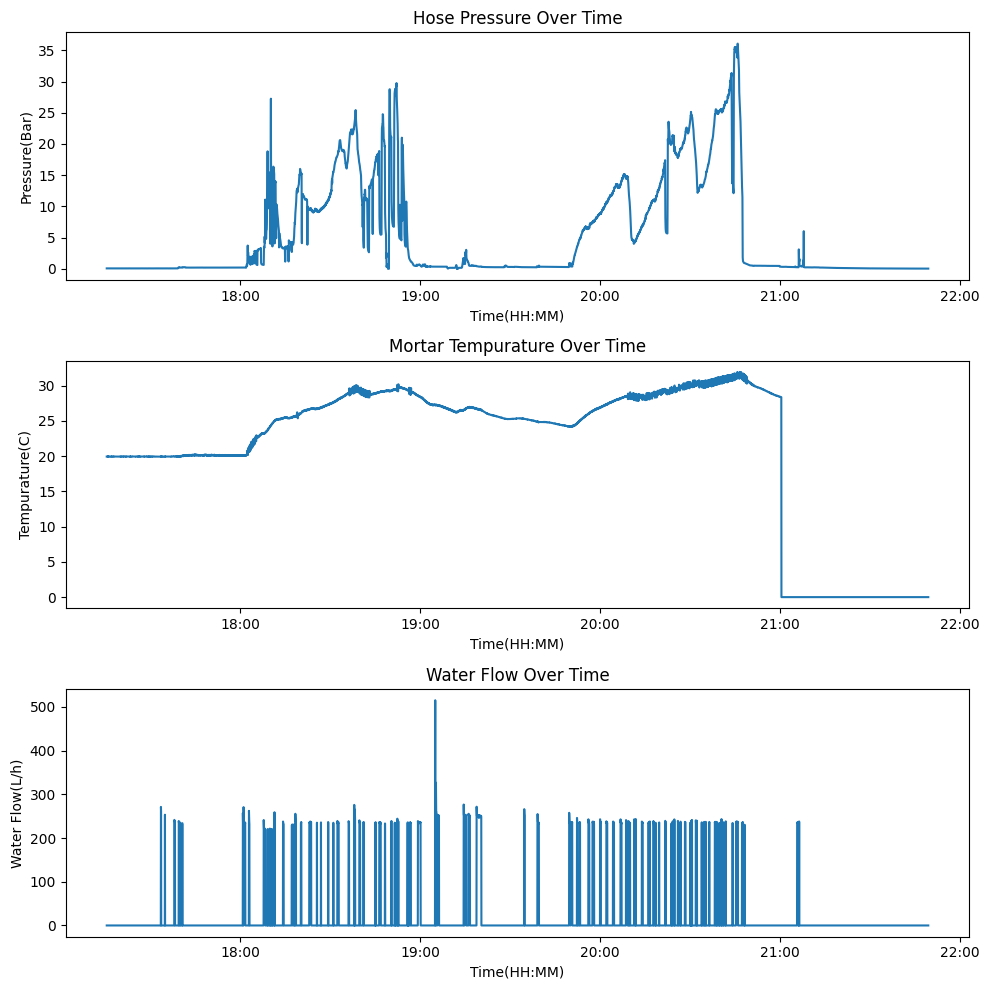

In [7]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
#first_run = [19895.669, 19895.679]
#second_run = [19895.691, 19895.699]

ax1.plot(df['timestamp'], df['GECO/MP_Pump_Pressure_Current_bar_R'])
myFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(myFmt)
ylim = ax1.get_ylim()
xlim = ax1.get_xlim()
#ax1.vlines(first_run, ylim[0], ylim[1], colors='red', label='First Run')
#ax1.vlines(second_run, ylim[0], ylim[1], colors='green', label='Second Run')
#ax1.legend()
# Adding axis labels and title
ax1.set_xlabel('Time(HH:MM)')
ax1.set_ylabel('Pressure(Bar)')
ax1.set_title('Hose Pressure Over Time')

ax2.plot(df['timestamp'], df['GECO/MPTX_DI_Mortar_Temperature_C_R'])
ax2.xaxis.set_major_formatter(myFmt)
ylim = ax2.get_ylim()
xlim = ax2.get_xlim()
#ax2.vlines(first_run, ylim[0], ylim[1], colors='red', label='First Run')
#ax2.vlines(second_run, ylim[0], ylim[1], colors='green', label='Second Run')
#ax2.legend()
# Adding axis labels and title
ax2.set_xlabel('Time(HH:MM)')
ax2.set_ylabel('Tempurature(C)')
ax2.set_title('Mortar Tempurature Over Time')
plt.tight_layout()

ax3.plot(df['timestamp'], df['GECO/MP_Waterflowrate_current_Lh_R'])
ax3.xaxis.set_major_formatter(myFmt)
ylim = ax3.get_ylim()
xlim = ax3.get_xlim()
#ax3.vlines(first_run, ylim[0], ylim[1], colors='red', label='First Run')
#ax3.vlines(second_run, ylim[0], ylim[1], colors='green', label='Second Run')
#ax3.legend()
# Adding axis labels and title
ax3.set_xlabel('Time(HH:MM)')
ax3.set_ylabel('Water Flow(L/h)')
ax3.set_title('Water Flow Over Time')
plt.tight_layout()

Text(0.5, 1.0, 'Air Humidity Over Time')

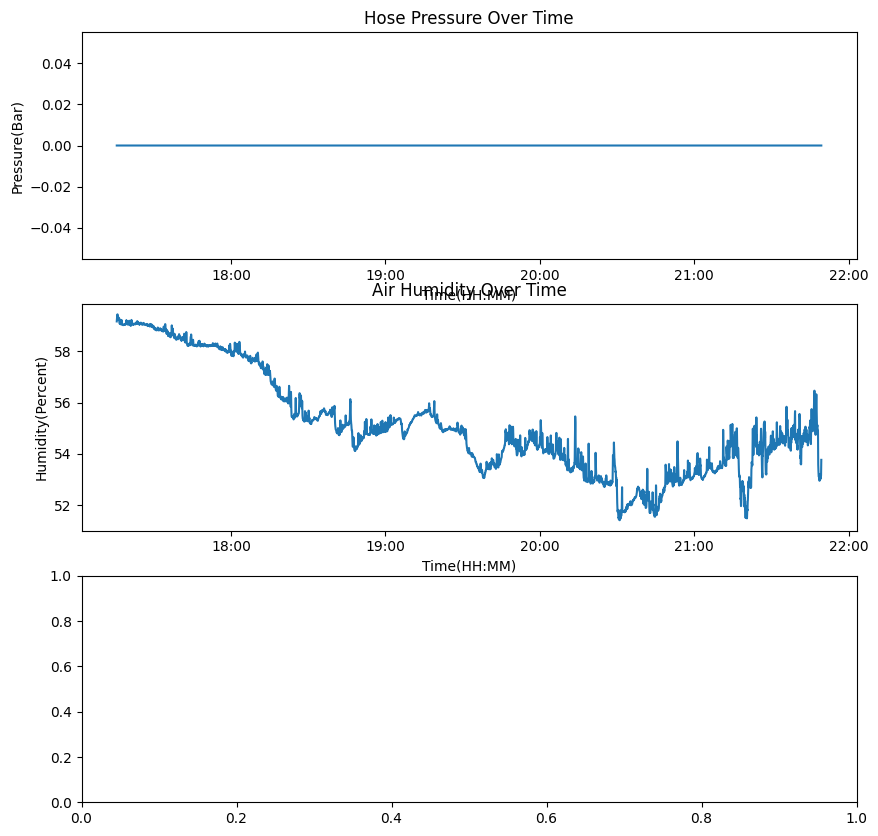

In [81]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
#first_run = [19895.669, 19895.679]
#second_run = [19895.691, 19895.699]

ax1.plot(df['timestamp'], df['GECO/MPRX_DI_DOS1_Flowrate_50Hz_mlmin_I'])
myFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(myFmt)
ylim = ax1.get_ylim()
xlim = ax1.get_xlim()
#ax1.vlines(first_run, ylim[0], ylim[1], colors='red', label='First Run')
#ax1.vlines(second_run, ylim[0], ylim[1], colors='green', label='Second Run')
#ax1.legend()
# Adding axis labels and title
ax1.set_xlabel('Time(HH:MM)')
ax1.set_ylabel('Pressure(Bar)')
ax1.set_title('Hose Pressure Over Time')

#MPTX_DI_Air_Humidity_pct_R

ax2.plot(df['timestamp'], df['GECO/MPTX_DI_Air_Humidity_pct_R'])
myFmt = mdates.DateFormatter('%H:%M')
ax2.xaxis.set_major_formatter(myFmt)
ylim = ax2.get_ylim()
xlim = ax2.get_xlim()
#ax1.vlines(first_run, ylim[0], ylim[1], colors='red', label='First Run')
#ax1.vlines(second_run, ylim[0], ylim[1], colors='green', label='Second Run')
#ax1.legend()
# Adding axis labels and title
ax2.set_xlabel('Time(HH:MM)')
ax2.set_ylabel('Humidity(Percent)')
ax2.set_title('Air Humidity Over Time')


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 62 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   timestamp                                      5961 non-null   datetime64[ns]
 1   GECO/MPRX_DI_DOS1_Flowrate_50Hz_mlmin_I        5961 non-null   int64         
 2   GECO/MPRX_DI_DOS2_Flowrate_50Hz_mlmin_I        5961 non-null   int64         
 3   GECO/MPRX_DI_DOS3_Flowrate_50Hz_mlmin_I        5961 non-null   int64         
 4   GECO/MPRX_DI_FOG_Flowrate_50Hz_lmin_I          5961 non-null   int64         
 5   GECO/MPRX_DI_FOG_Foam_Air_Factor_I             5961 non-null   int64         
 6   GECO/MPRX_DI_FOG_Foam_Density_gl_I             5961 non-null   int64         
 7   GECO/MPRX_DI_FOG_Foam_Loss_Factor_pct_I        5961 non-null   int64         
 8   GECO/MPRX_DI_FOG_Foamingagent_pct_R            5961 non-nu

In [10]:
df.describe()

,timestamp,GECO/MPRX_DI_DOS1_Flowrate_50Hz_mlmin_I,GECO/MPRX_DI_DOS2_Flowrate_50Hz_mlmin_I,GECO/MPRX_DI_DOS3_Flowrate_50Hz_mlmin_I,GECO/MPRX_DI_FOG_Flowrate_50Hz_lmin_I,GECO/MPRX_DI_FOG_Foam_Air_Factor_I,GECO/MPRX_DI_FOG_Foam_Density_gl_I,GECO/MPRX_DI_FOG_Foam_Loss_Factor_pct_I,GECO/MPRX_DI_FOG_Foamingagent_pct_R,GECO/MPRX_DI_FOG_RESERVED_Foamingagent_cpct_I,...,GECO/MPXMB_Mixer_OutputCurrent_dA_I,GECO/MPXMB_Pump_OutputCurrent_dA_I,GECO/MPXMB_Pump_OutputPower_W_I,GECO/MPXMB_Waterpump_OutputFrequency_cHz_I,GECO/MPYMB_Waterpump_FrequencyRef_cHz_I,GECO/MP_DOS1_Flowrate_current_mlmin_I,GECO/MP_DOS2_Flowrate_current_mlmin_I,GECO/MP_DOS3_Flowrate_current_mlmin_I,GECO/MP_Pump_Pressure_Current_bar_R,GECO/MP_Waterflowrate_current_Lh_R
count,5961,5961.0,5961.0,5961.0,5961.0,5961.0,5961.0,5961.0,5961.0,5961.0,...,5961.0,5961.000000,5961.000000,5961.000000,5961.000000,5961.0,5961.0,5961.0,5961.000000,5961.000000
mean,2024-08-04 19:32:36.158046720,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,20.443214,156.462003,200.294581,2008.262540,0.0,0.0,0.0,5.364629,20.072771
min,2024-08-04 17:15:38.264167,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,1863.000000,0.0,0.0,0.0,0.000000,0.000000
25%,2024-08-04 18:24:20.267783936,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,1977.000000,0.0,0.0,0.0,0.190260,0.000000
50%,2024-08-04 19:32:38.193146112,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,38.000000,140.000000,0.000000,1985.000000,0.0,0.0,0.0,0.380983,0.000000
75%,2024-08-04 20:40:54.301360128,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,40.000000,300.000000,0.000000,1992.000000,0.0,0.0,0.0,9.651711,0.000000
max,2024-08-04 21:49:20.745654,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,88.000000,1070.000000,6155.000000,6000.000000,0.0,0.0,0.0,36.072330,515.027039
std,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,19.929822,178.235612,642.584811,203.900119,0.0,0.0,0.0,7.867551,66.517821


In [11]:
#df.to_csv("First_Run_Data_Log.csv")

In [103]:
robot = pd.read_csv("0842024_RobotMotion.csv", low_memory=False)
#robot = robot[:400000]
#robot = robot.astype({'A3 Velo':'float64'})

In [51]:
robot.dtypes

Name                 int64
2K Mixer Torque    float64
A1 Velo            float64
A1 Acc             float64
A2 Acc               int64
A2 Velo            float64
A3 Acc               int64
A3 Velo            float64
A4 Acc               int64
A4 Velo            float64
A5 Acc               int64
A5 Velo            float64
A6 Acc             float64
A6 Velo            float64
dtype: object

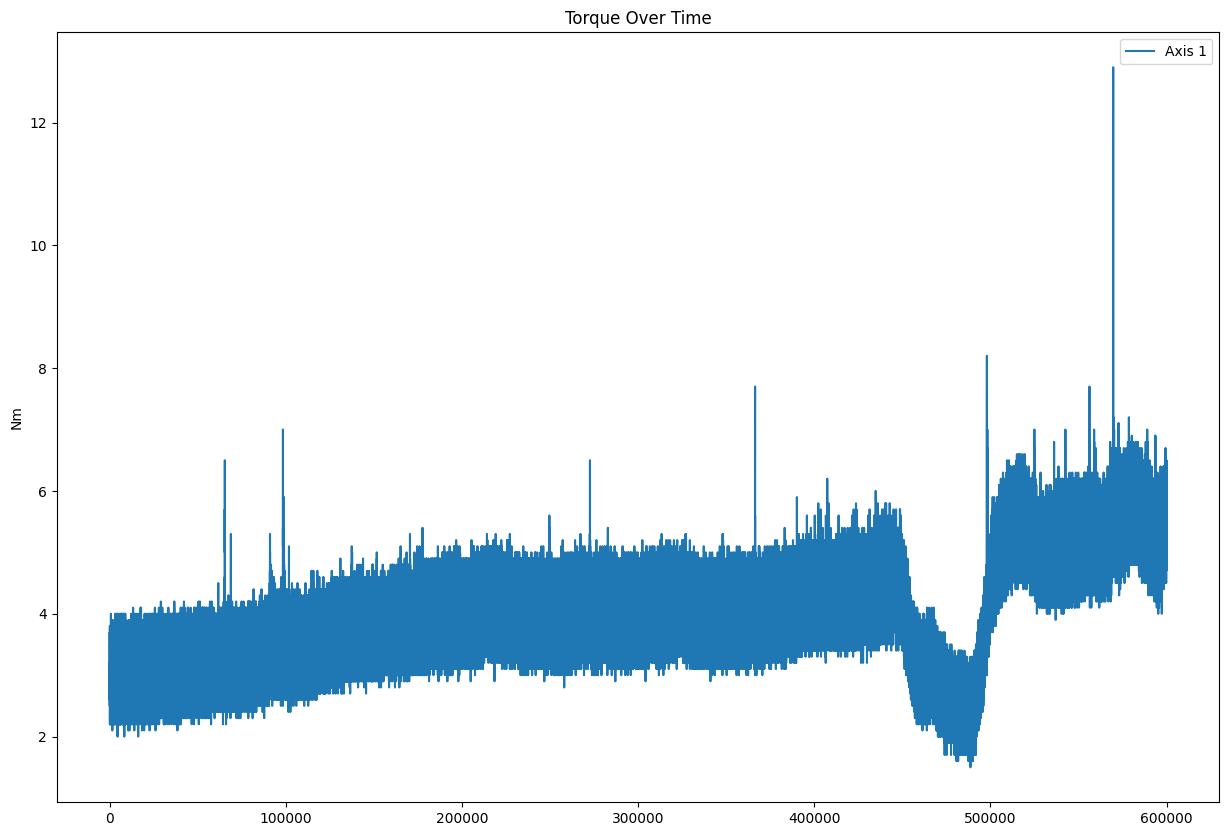

In [104]:
# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.plot(robot['2K Mixer Torque'], label='Axis 1')
#ax.plot(robot['A2 Acc'][0:400000], label='Axis 2')
#ax.plot(robot['A3 Acc'][0:400000], label='Axis 3')
#ax.plot(robot['A4 Acc'][0:400000], label='Axis 4')
#ax.plot(robot['A5 Acc'][0:400000], label='Axis 5')
#ax.plot(robot['A6 Acc'][0:400000], label='Axis 6')
#ax1.set_xlabel('Time(HH:MM)')
ax.set_ylabel('Nm')
ax.set_title('Torque Over Time')
ax.legend()

In [38]:
robot.dtypes

Name                 int64
2K Mixer Torque    float64
A1 Velo            float64
A1 Acc             float64
A2 Acc               int64
A2 Velo            float64
A3 Acc               int64
A3 Velo             object
A4 Acc               int64
A4 Velo            float64
A5 Acc               int64
A5 Velo            float64
A6 Acc             float64
A6 Velo            float64
dtype: object

In [46]:
#robot = robot[:400000]

In [65]:
construct = pd.read_csv("ttyACM0-test.csv", low_memory=False)

In [66]:
construct

,timestamp,sensor,temp,type
0,8/4/2024 13:35,Temp01,21.75,0
1,8/4/2024 13:36,Temp02,21.62,0
2,8/4/2024 13:36,Temp03,21.69,0
3,8/4/2024 13:36,Temp04,21.56,0
4,8/4/2024 13:36,Temp05,21.69,0
...,...,...,...,...
503,8/4/2024 13:20,Temp04,28.62,0
504,8/4/2024 13:20,Temp05,30.50,0
505,8/4/2024 13:20,Temp01,30.44,0
506,8/4/2024 13:20,Temp02,30.62,0


In [71]:
sense1 = construct[construct['sensor']=='Temp01']
sense2 = construct[construct['sensor']=='Temp02']
sense3 = construct[construct['sensor']=='Temp03']
sense4 = construct[construct['sensor']=='Temp04']
sense5 = construct[construct['sensor']=='Temp05']

In [69]:
sense1

,timestamp,sensor,temp,type
0,8/4/2024 13:35,Temp01,21.75,0
5,8/4/2024 13:36,Temp01,21.81,0
10,8/4/2024 13:36,Temp01,21.75,0
15,8/4/2024 13:36,Temp01,21.75,0
20,8/4/2024 13:36,Temp01,21.75,0
...,...,...,...,...
485,8/4/2024 13:19,Temp01,30.50,0
490,8/4/2024 13:19,Temp01,30.50,0
495,8/4/2024 13:19,Temp01,30.50,0
500,8/4/2024 13:20,Temp01,30.50,0


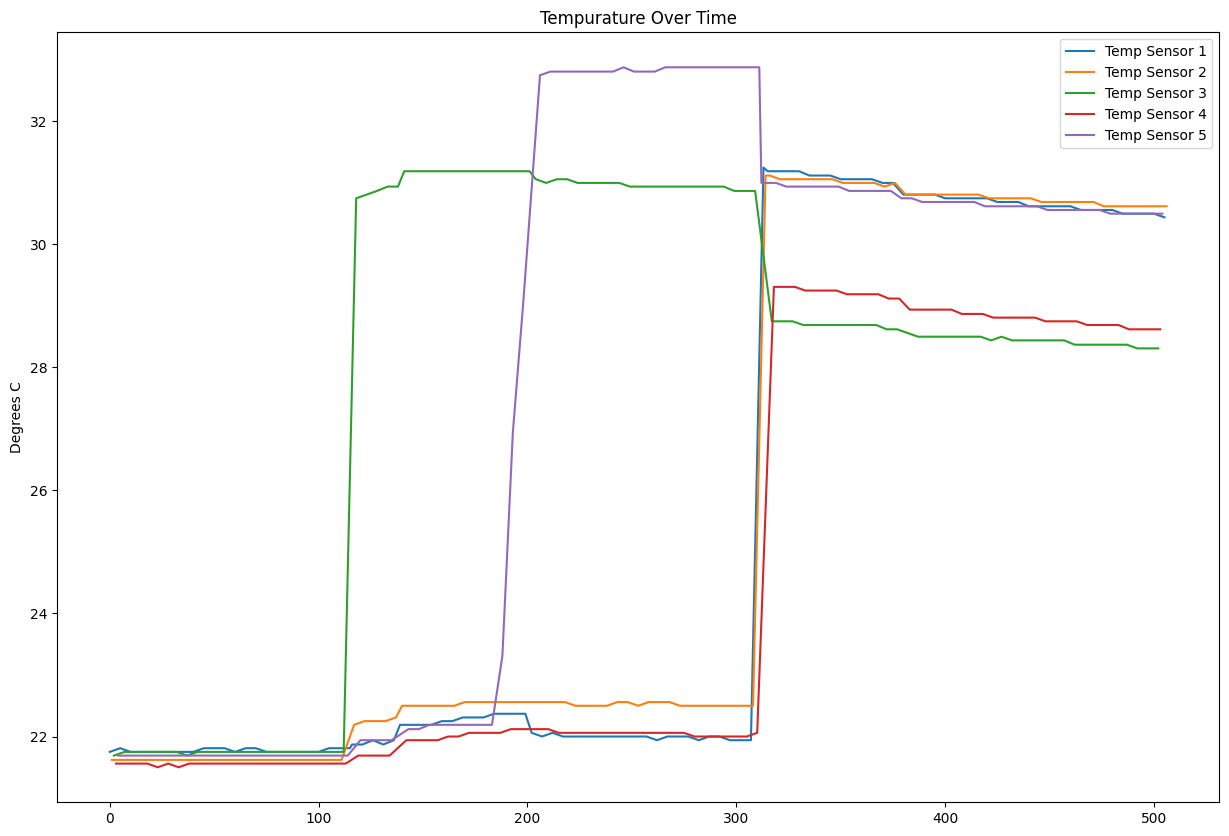

In [72]:
# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.plot(sense1['temp'], label='Temp Sensor 1')
ax.plot(sense2['temp'], label='Temp Sensor 2')
ax.plot(sense3['temp'], label='Temp Sensor 3')
ax.plot(sense4['temp'], label='Temp Sensor 4')
ax.plot(sense5['temp'], label='Temp Sensor 5')
#ax1.set_xlabel('Time(HH:MM)')
ax.set_ylabel('Degrees C')
ax.set_title('Tempurature Over Time')
ax.legend()

In [75]:
construct_moist = pd.read_csv("ttyACM1-test.csv", low_memory=False)

In [76]:
construct_moist

,timestamp,sensor,temp,type
0,8/4/2024 13:35,sensorA0,474,1
1,8/4/2024 13:35,sensorA1,481,1
2,8/4/2024 13:35,sensorA2,475,1
3,8/4/2024 13:35,sensorA3,473,1
4,8/4/2024 13:36,sensorA4,476,1
...,...,...,...,...
413,8/4/2024 13:18,sensorA3,471,1
414,8/4/2024 13:18,sensorA4,475,1
415,8/4/2024 13:18,sensorA0,203,1
416,8/4/2024 13:18,sensorA1,476,1


In [90]:
sense_moist1 = construct_moist[construct_moist['sensor']=='sensorA0']
sense_moist2 = construct_moist[construct_moist['sensor']=='sensorA1']
sense_moist3 = construct_moist[construct_moist['sensor']=='sensorA3']

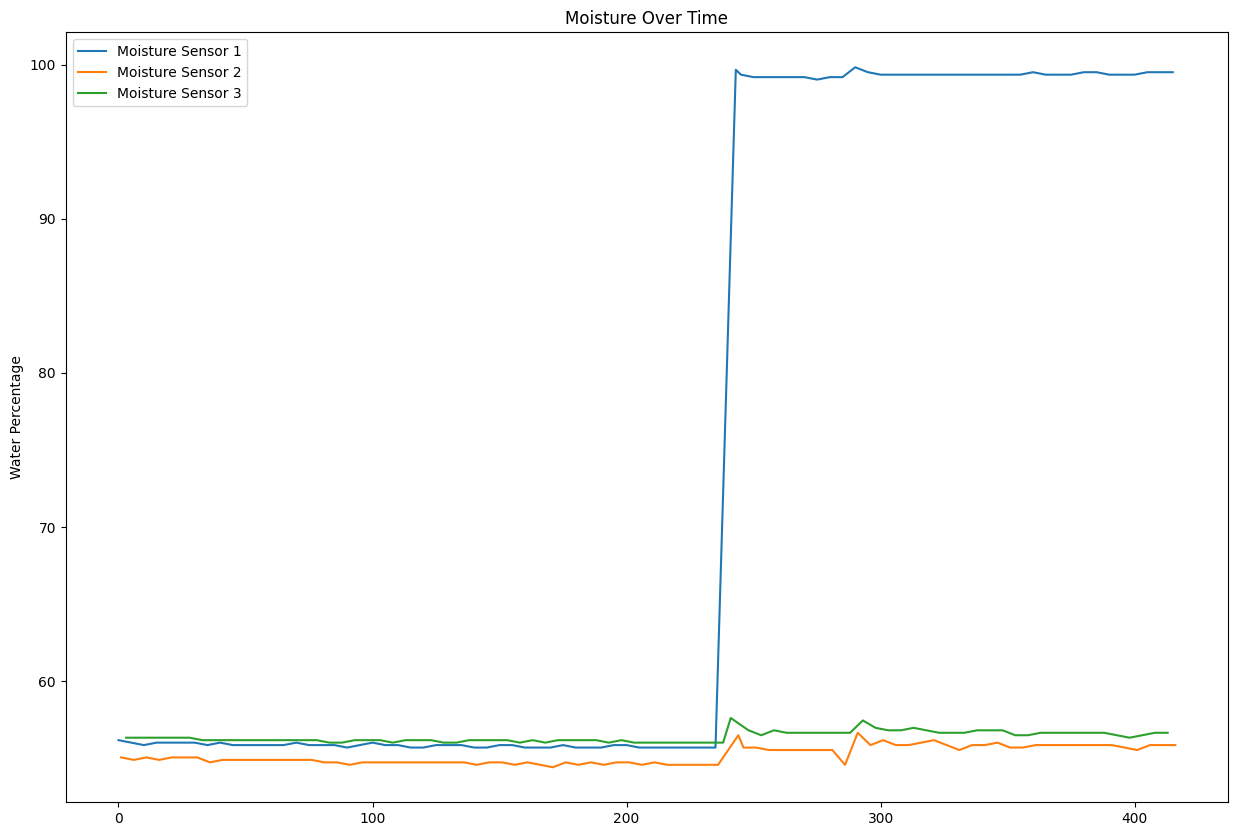

In [91]:
# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.plot(sense_moist1['temp'].apply(translate), label='Moisture Sensor 1')
ax.plot(sense_moist2['temp'].apply(translate), label='Moisture Sensor 2')
ax.plot(sense_moist3['temp'].apply(translate), label='Moisture Sensor 3')
#ax1.set_xlabel('Time(HH:MM)')
ax.set_ylabel('Water Percentage')
ax.set_title('Moisture Over Time')
ax.legend()

In [82]:
def translate(value):
    leftMax = 200
    leftMin = 500

    rightMin = 52
    rightMax = 100
    
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [84]:
translate(450)

60.0

In [96]:
head = pd.read_csv("ttyACM2-test.csv", low_memory=False)
head

,timestamp,sensor,temp,type
0,8/4/2024 13:35,Head01,31.69,2.0
1,8/4/2024 13:36,Head02,30.81,2.0
2,8/4/2024 13:36,Head01,31.69,2.0
3,8/4/2024 13:36,Head02,30.81,2.0
4,8/4/2024 13:36,Head01,31.75,2.0
...,...,...,...,...
277,8/4/2024 13:21,Head02,32.44,2.0
278,8/4/2024 13:21,Head01,32.63,2.0
279,8/4/2024 13:21,Head02,32.38,2.0
280,8/4/2024 13:21,Head01,32.56,2.0


In [93]:
sense_head1 = head[head['sensor']=='Head01']
sense_head2 = head[head['sensor']=='Head02']

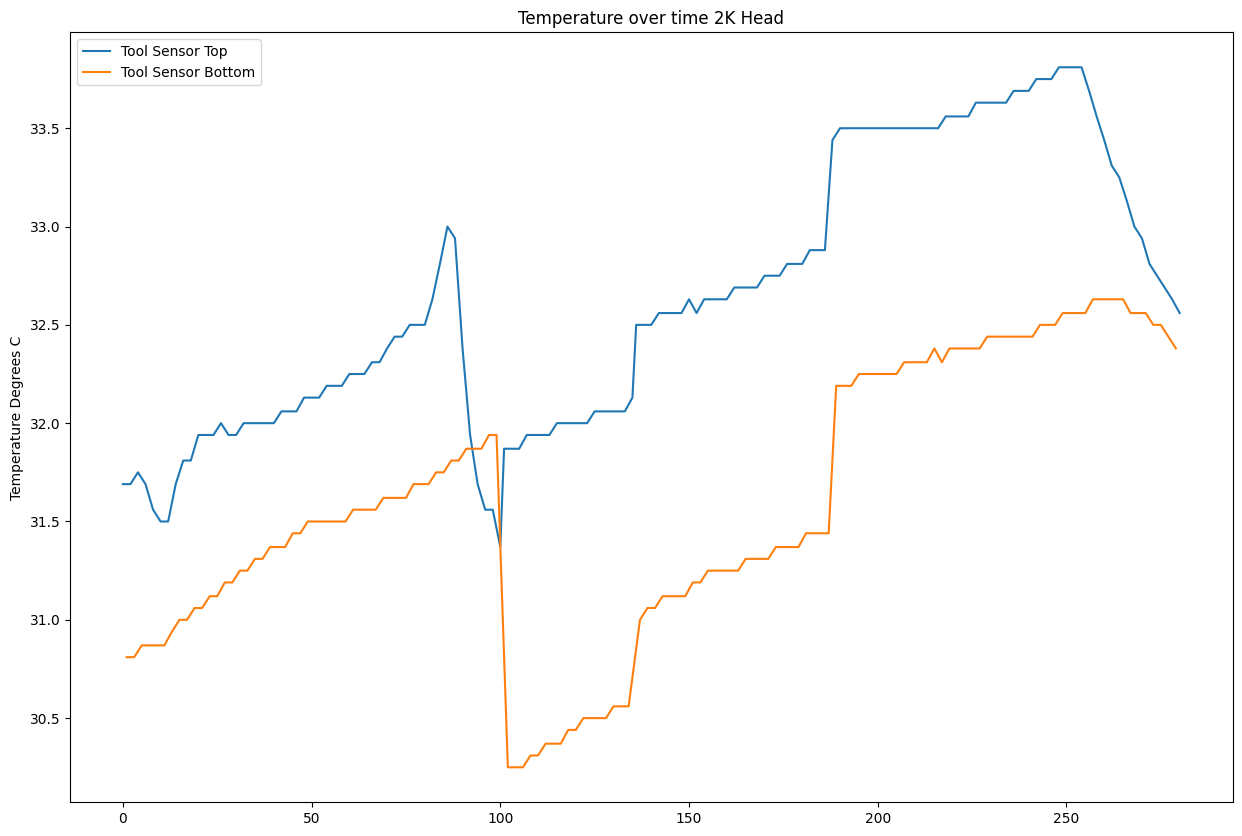

In [99]:
# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.plot(sense_head1['temp'], label='Tool Sensor Top')
ax.plot(sense_head2['temp'], label='Tool Sensor Bottom')
#ax1.set_xlabel('Time(HH:MM)')
ax.set_ylabel('Temperature Degrees C')
ax.set_title('Temperature over time 2K Head')
ax.legend()